<h1>Semantic Segmentation with Mask R-CNN</h1>
<p>This program utilize the Mask R-CNN implemented in the Torch Vision library for semantic segmentation. Torch Vision provides a lot of pre-trained networks for very handy computer vision tasks. Please read <a href="https://pytorch.org/vision/stable/index.html">https://pytorch.org/vision/stable/index.html</a> for more information. The program is modified from <a href="https://debuggercafe.com/instance-segmentation-with-pytorch-and-mask-r-cnn/">https://debuggercafe.com/instance-segmentation-with-pytorch-and-mask-r-cnn/</a>, with a new program flow and extra functionalities to facilitate a better understanding.</p>

<h1>Importing Libraries</h1>

In [2]:
import cv2
import numpy as np
import random
import torch
import torchvision
from PIL import Image
from IPython import display
from torchvision.transforms import transforms

# The 91 COCO class names
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# Generate a set of color for drawing different classes
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# Transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if (torch.cuda.device_count()>0):
    print(torch.cuda.get_device_name(0))


cuda:0
NVIDIA GeForce GTX 1080 Ti


<h1>Initializing the Mask R-CNN from the Torchvision Library</h1>
<p>Learning points:</p>
<ul>
    <li>What network are we initializing?</li>
    <li>What are the other pre-trained networks provided by Torchvision?</li>
    <li>What information does eval() provide?</li>
</ul>

In [3]:
# Initialize the model and set it to the evaluation mode
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=91)
model.to(device).eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to C:\Users\Jack/.cache\torch\hub\checkpoints\maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:04<00:00, 37.4MB/s] 


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

<h1>Loading the Image</h1>
<p>Learning points</p>
<ul>
<li>How to use Open CV functions to display an image?</li>
<li>Why do we need to convert the color space for image display?</li>
</ul>

./PeepsShot.png


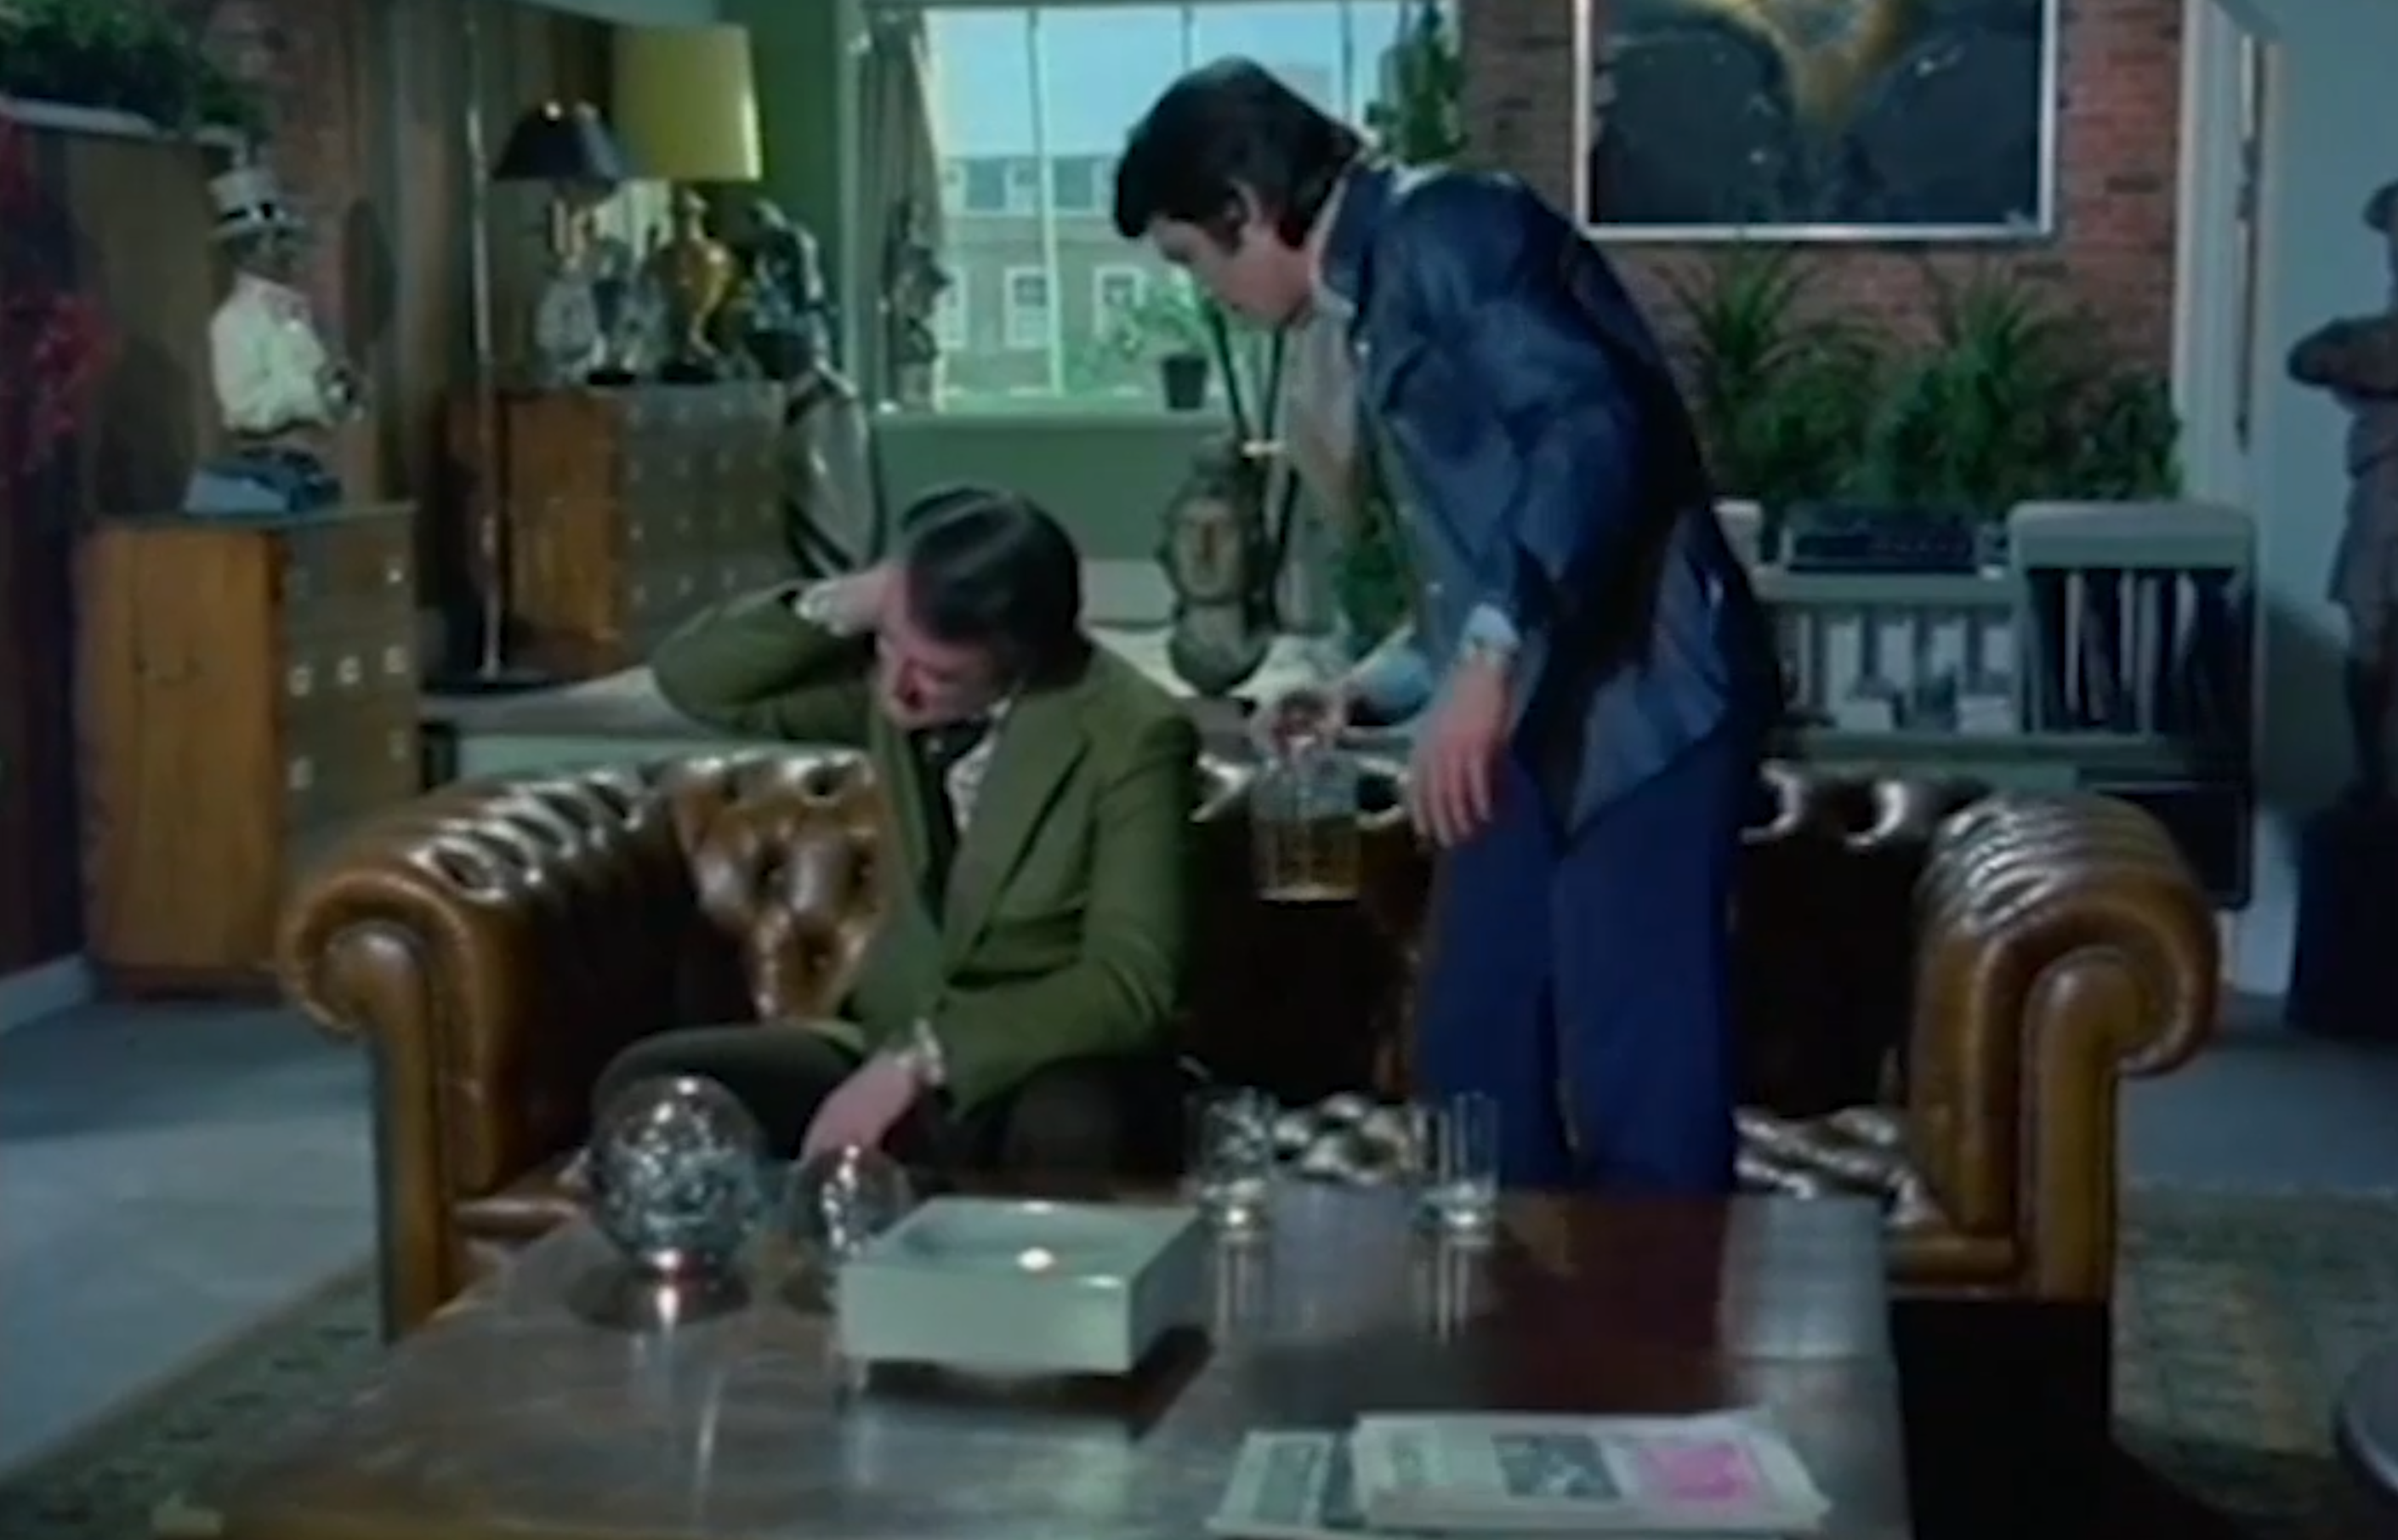

In [5]:
# Upload an image
filename = "./PeepsShot.png"
print(filename)

# Load the image
in_frame = cv2.imread(filename, cv2.IMREAD_COLOR)

# Display the image
d = display.display(None, display_id=True)
in_frame_display = cv2.cvtColor(in_frame, cv2.COLOR_BGR2RGB) # Convert from CV2's BGR to RGB
d.update(Image.fromarray(in_frame_display))



<h1>Analyzing the Image with Mask R-CNN</h1>
<p>Learning points:</p>
<ul>
    <li>What is the data structure that stores the detected objects?</li>
    <li>How many objects are detected and how many do we consider?</li>
    <li>What information is provided for each detected objects?</li>
    </ul>

In [6]:
# Analyze the image
in_frame_processing = cv2.cvtColor(in_frame, cv2.COLOR_BGR2RGB) # Convert from CV2's BGR to RGB
in_frame_processing = transform(in_frame_processing) # Convert the image to tensor
in_frame_processing = in_frame_processing.unsqueeze(0).to(device) # add a batch dimension
with torch.no_grad():
    outputs = model(in_frame_processing)

# Get individual types of output from the outputs variable
scores = list(outputs[0]['scores'].detach().cpu().numpy()) # Get scores
print(scores) # The scores are sorted from largest to the shortest
thresholded_objects = [scores.index(i) for i in scores if i > 0.965] # Get an index for the objects having the scores > a threshold of 0.965
thresholded_objects_count = len(thresholded_objects) # Total objects having scores > threshold
masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy() # Get the segmentation masks
masks = masks[:thresholded_objects_count] # Discard masks for objects that are below threshold by only taking the beginning of the list
boxes = [[(i[0], i[1]), (i[2], i[3])]  for i in outputs[0]['boxes'].detach().cpu()] # Get the bounding boxes, in (x1, y1), (x2, y2) format
boxes = boxes[:thresholded_objects_count] # Discard bounding boxes for objects that are below threshold by only taking the beginning of the list
labels = [coco_names[i] for i in outputs[0]['labels']] # Get the classes labels

# Print all the detected objects
for i in range(0, len(outputs[0]['scores'])):
    print(coco_names[outputs[0]['labels'][i]], ":", float(outputs[0]['scores'][i]), "(", int(outputs[0]['boxes'][i][0]), int(outputs[0]['boxes'][i][1]), int(outputs[0]['boxes'][i][2]), int(outputs[0]['boxes'][i][3]) ,")")


[0.9916432, 0.9889516, 0.9546004, 0.91757786, 0.9141066, 0.84882903, 0.8127843, 0.79740375, 0.7631352, 0.6861227, 0.64873934, 0.6288565, 0.608662, 0.5856754, 0.5557114, 0.5250628, 0.47637096, 0.47103345, 0.47072425, 0.46237448, 0.43102014, 0.41623375, 0.41086194, 0.41073668, 0.40907902, 0.38393676, 0.36472, 0.3467916, 0.28272474, 0.27513927, 0.27285194, 0.2661574, 0.2654666, 0.260378, 0.2482774, 0.23351505, 0.22129194, 0.20307335, 0.20180528, 0.19435303, 0.19232197, 0.1885912, 0.18806678, 0.174519, 0.169173, 0.1490374, 0.1401012, 0.13092272, 0.12904172, 0.12683095, 0.12556496, 0.121218786, 0.10954928, 0.10842113, 0.10786043, 0.098253936, 0.09700472, 0.095233634, 0.09366263, 0.09290603, 0.09169291, 0.086011365, 0.08252525, 0.081232026, 0.07433417, 0.0736857, 0.073641025, 0.06365367, 0.06266957, 0.06264324, 0.061168253, 0.061013155, 0.05878401, 0.058464, 0.05680829, 0.056780405, 0.051956806, 0.051436298, 0.051326733, 0.050311733, 0.05011657]
person : 0.9916431903839111 ( 1343 74 2082 145

<h1>Visualizing the Results</h1>
<p>Learning points:</p>
<ul>
    <li>How to use different cv2 drawing functions to visualize the results?</li>
    <li>How to render a mask with cv2?</li>
    <li>How to display and save an image?</li>
    </ul>

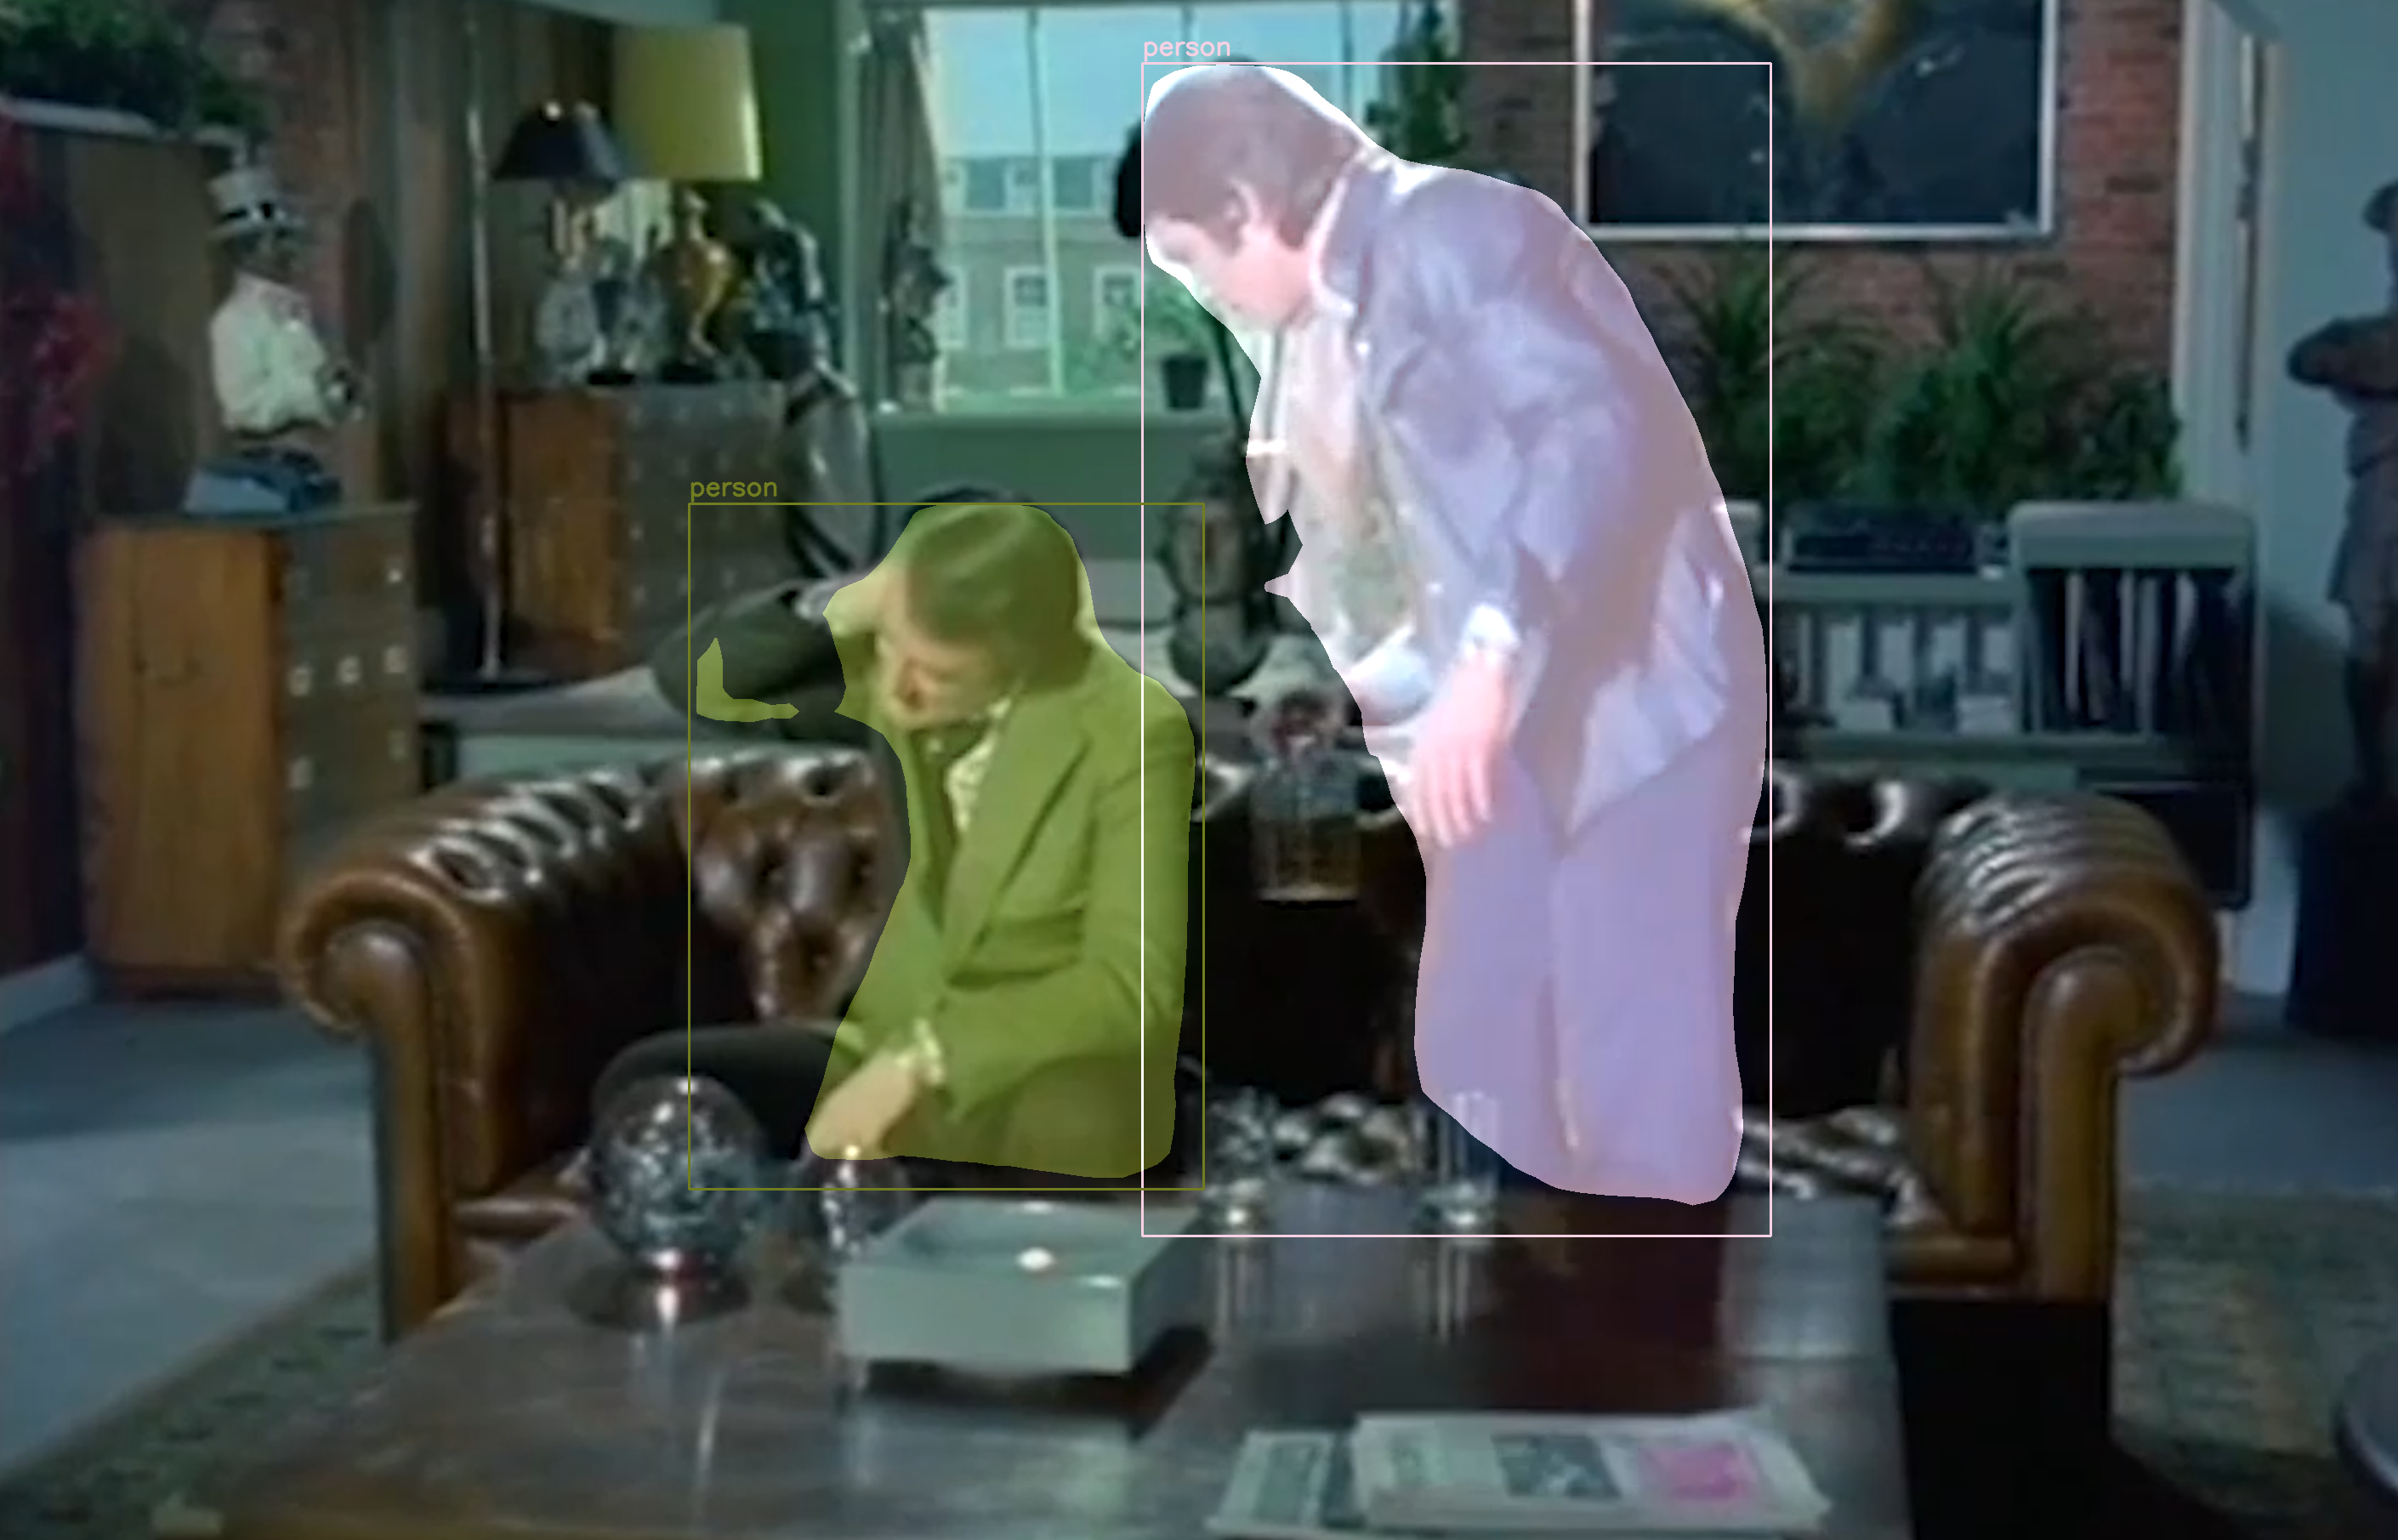

In [9]:
# Get the image 
out_frame = in_frame.copy()
out_frame = np.array(out_frame)

# Draw the segmentation masks with the text labels
for i in range(len(masks)): # For all detected objects with score > threshold
    color = COLORS[random.randrange(0, len(COLORS))] # Pick a random color
    red_map = np.zeros_like(masks[i]).astype(np.uint8) # Initialize an empty mask for each of the RGB channels
    green_map = np.zeros_like(masks[i]).astype(np.uint8)
    blue_map = np.zeros_like(masks[i]).astype(np.uint8)
    red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1] = color # Set the color of the masked pixels
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2) # Combine the three channels of the mask
    cv2.addWeighted(out_frame, 1.0, segmentation_map, 0.6, 0.0, out_frame) # Apply the mask onto the image
    cv2.rectangle(out_frame, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])), color, 2) # Draw the bounding boxes
    cv2.putText(out_frame , labels[i], (int(boxes[i][0][0]), int(boxes[i][0][1])-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA) # Draw the class label as text

# Save the image
cv2.imwrite("./output.png", out_frame)

# Display the image
d = display.display(None, display_id=True)
out_frame_display = cv2.cvtColor(out_frame, cv2.COLOR_BGR2RGB) # Convert from CV2's BGR to RGB
d.update(Image.fromarray(out_frame_display))
    
